In [1]:
# Watch for Changes and Reload
%load_ext autoreload
%autoreload 2

In [19]:
from data_load import MaskDataset, Normalize, ToTensor, Rescale, RandomCrop
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np

In [3]:
path_to_df =  "dataset_paths.csv"
custom_transform = transforms.Compose([Rescale(700), RandomCrop(640), Normalize(), ToTensor()])
mask_dataset = MaskDataset(path_to_df, transform=custom_transform)

print("Number of images and masks : {}".format(len(mask_dataset)))

Number of images and masks : 1766


In [4]:
mask_dataset[2]['image'].shape, mask_dataset[2]['mask'].shape

(torch.Size([3, 640, 640]), torch.Size([1, 640, 640]))

In [5]:
# Split the Training data into 80%Train/20%Validation 

from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 8

train_sampler = SubsetRandomSampler(range(1412)) # about 80% of the training images 
validation_sampler = SubsetRandomSampler(range(1412,len(mask_dataset)))

train_loader = DataLoader(mask_dataset, 
                          batch_size=batch_size,
                          num_workers=4,
                          sampler=train_sampler)

# Create a Validation Set. ( It seems that we can't use data/test for validation as they are copies from the training data)
validation_loader = DataLoader(mask_dataset, 
                               batch_size=batch_size,
                               num_workers=4,
                               sampler=validation_sampler)

In [6]:
# Load model
from models import FCN32s, VGGNet

vgg_model = VGGNet()
model = FCN32s(vgg_model, 1).cuda()

In [7]:
# Pass a sample through the model
#sample = model(mask_dataset[0]['image'])
#sample.shape
for batch in train_loader:
    print(batch['image'].shape)
    print(model(batch['image'].cuda()).shape)
    #print(model(batch['image']))
    break


torch.Size([8, 3, 640, 640])
torch.Size([8, 1, 640, 640])


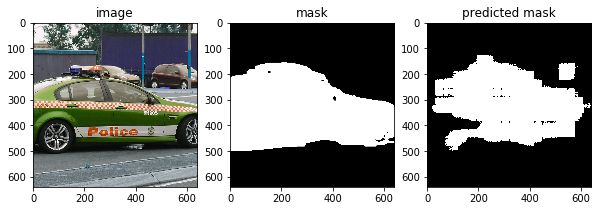

In [15]:
# Show some images before training

def show_image(image_idx):
    im = np.transpose(mask_dataset[image_idx]['image'], (1,2,0))
    mk = np.transpose(mask_dataset[image_idx]['mask'], (1,2,0))
    pred = model(mask_dataset[image_idx]['image'].unsqueeze(0).cuda())
    pred = np.round(pred.cpu().detach().numpy())  # Copy from GPU->host mem
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,20))
    ax1.imshow(im)
    ax1.set_title("image")
    ax2.imshow(np.squeeze(mk), cmap='gray')
    ax2.set_title("mask")
    ax3.imshow(np.squeeze(pred), cmap='gray')
    ax3.set_title("predicted mask")
    plt.show()

show_image(0)

In [ ]:

def train_epoch():
    model.train()
    running_loss = 0.0
    num_batches = 0
    for batch_i, data in enumerate(train_loader):
        images = data['image'].cuda()
        masks = data['mask'].cuda()
        output_masks = model(images)
        loss = criterion(output_masks, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    print("Training Loss : {}".format(running_loss/num_batches))
    

def validation_epoch():
    model.eval()
    running_loss = 0.0
    num_batches = 0
    for batch_i, data in enumerate(validation_loader):
        images = data['image'].cuda()
        masks = data['mask'].cuda()
        output_masks = model(images)
        loss = criterion(output_masks, masks)
        running_loss += loss.item()
        num_batches += 1
    
    print("Validation Loss : {}".format(running_loss/num_batches))

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(n_epochs=200):
    for epoch in range(n_epochs):
        print("Epoch : {}".format(epoch))
        train_epoch()
        validation_epoch()

train()

Epoch : 0
Training Loss : 0.6257580673627261
Validation Loss : 0.7920804222424825
Epoch : 1
Training Loss : 0.5447244349509309
Validation Loss : 0.5376335680484772
Epoch : 2
Training Loss : 0.516018294681937
Validation Loss : 0.6428913209173415
Epoch : 3


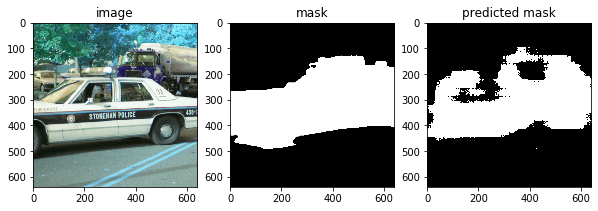

In [16]:
# Visualize Some Results.
show_image(1500)

In [20]:
# Save the model 
model_dir = 'saved_models/'
model_name = 'mask_model_1.pt'

torch.save(model.state_dict(), model_dir+model_name)